In [82]:
import sys
sys.path.append('/home/karthik/code/pyrobo/src/')

In [83]:
import serial
ser = serial.Serial("/dev/ttyACM0")

SerialException: [Errno 2] could not open port /dev/ttyACM0: [Errno 2] No such file or directory: '/dev/ttyACM0'

In [84]:
ser.write("#2P1500#5P1500#8P1500#14P1500#15P1500#10P1500T600\r\n")

SerialException: write failed: [Errno 5] Input/output error

In [21]:
/.ser.write("#2P1500#5P1500#8P1500#14P1100#15P1500#10P1500T600\r\n")

51

In [5]:
ser.write("#10P1700T600\r\n")

14

In [ ]:
ser.close()

In [17]:
import numpy as np
import tensorflow as tf

### Robot lib

In [79]:
from transforms import Tx, Ty, Tz, Rx, Ry, Rz
robo_init = {2:1500, 5:1500, 8:1500, 14:1500, 15:1500, 10:1500 }

L1Z = 100; L2X = 25; L2Z = 10; L3Z = 100; L4Z = 100; L5Z = 25; L5X = 50; L6X = 190;
        
def robot_function_base(q1, q2, q3, q4, q5):
    return Tz(L1Z)*Rz(q1)*Tx(L2X)*Tz(L2Z)*Ry(q2)*Tz(L3Z)*Ry(-q3)*Tz(L4Z)*Ry(-q4)*Tz(L5Z)*Tx(L5X)*Rx(q5)*Tx(L6X)

    
def robot_function(q):
    return robot_function_base(q[0], q[1], q[2], q[3], q[4])
    
MOTOR_PORTS = [2, 5, 8, 14, 15, 10]

def radian_to_pulse_width(angle_in_radians):
    return 2*angle_in_radians/pi*1000 + 1500

def pulse_width_to_radians(pulse_width):
    return (pulse_width - 1500)/2000*np.pi

def fkine_from_pw(pwarr):
    q = [pulse_width_to_radians(x) for x in pwarr]
    print q
    return robot_function(q)

def thr_to_zero(mtrx):
    mtrx[mtrx<1e-8] = 0
    return mtrx

def is_valid(mtrx):
    z = mtrx[2,3]
    x = mtrx[0,3]
    if z<20:
        return False
    if x < 40 and z < 300:
        return False
    return True

def is_feasible_pos(pos):
    mtrx = fkine_from_pw([pos[mtr] for mtr in MOTOR_PORTS])
    return is_valid(mtrx)

def random_step():
    if np.random.rand() < 0.5:
        return -100
    return 100

def get_random_move(init_pos):
    motor_pos = init_pos.items()
    final_pos = init_pos.copy()
    motor, current_pos = motor_pos[np.random.randint(len(motor_pos))]
    final_pos[motor] = current_pos + random_step()
    return final_pos

def valid_random_move(init_pos):
    final_position = get_random_move(init_pos)
    while not is_feasible_pos(final_position):
        final_position = get_random_move(init_pos)
    return final_position

def to_move_string(pos):
    pos_str = ''.join(map(lambda (motor_id, post): "#%dP%d" % (motor_id, post),
                                  pos.items()))+"T%d\r\n" % 600
    return pos_str

### Camera lib

In [15]:
from operator import mul
import urllib2

im_shape = (480, 640, 3)
im_sz = reduce(mul, im_shape)

def from_buffer(im_str):
    f1 = np.fromstring(im_str, dtype=np.uint8)
    return f1.reshape((480, 640, 3))    
    
def get_images():
    response=urllib2.urlopen('http://localhost:8888/')
    left = from_buffer(response.read(im_sz))
    right = from_buffer(response.read(im_sz))
    response.close()
    return left, right


In [8]:
%matplotlib inline
from matplotlib import pyplot as pl

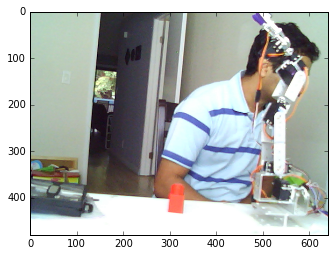

In [46]:
left, right = get_images()

pl.imshow(right)

In [18]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


In [81]:
current_pos = robo_init
ms = to_move_string(current_pos)
ser.write(ms + '\n')


52

In [80]:
import time

example = tf.train.Example()
filename = '/data/robotics/raw_position_images/train_2' + '.tfrecords'
writer = tf.python_io.TFRecordWriter(filename)

for j in range(10):
    current_pos = robo_init
    ms = to_move_string(current_pos)
    ser.write(ms + '\pi pi n')
    for i in range(50):
        current_pos = valid_random_move(current_pos)
        ms = to_move_string(current_pos)
        print ms
        mpos = [current_pos[2], current_pos[5], current_pos[8], current_pos[14], current_pos[15], current_pos[10]]
        print mpos
        ser.write(ms + '\n')
        time.sleep( 2)
        (left, right) = get_images()
        example_out = tf.train.Example(features=tf.train.Features(feature={
                'pos': _float_feature(mpos),
                'left_image': _bytes_feature(left.tostring()),
                'right_image': _bytes_feature(right.tostring())}))
        writer.write(example_out.SerializeToString())
        print i,j
    

writer.close()        


[0.0, 0.0, 0.0, -3.141592653589793, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
#2P1500#5P1500#8P1600#10P1500#14P1500#15P1500T600

[1500, 1500, 1600, 1500, 1500, 1500]
0 0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
#2P1500#5P1600#8P1600#10P1500#14P1500#15P1500T600

[1500, 1600, 1600, 1500, 1500, 1500]
1 0
[0.0, 0.0, 0.0, -3.141592653589793, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
#2P1500#5P1600#8P1500#10P1500#14P1500#15P1500T600

[1500, 1600, 1500, 1500, 1500, 1500]
2 0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
#2P1500#5P1600#8P1500#10P1500#14P1600#15P1500T600

[1500, 1600, 1500, 1600, 1500, 1500]
3 0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
#2P1500#5P1600#8P1600#10P1500#14P1600#15P1500T600

[1500, 1600, 1600, 1600, 1500, 1500]
4 0
[-3.141592653589793, 0.0, 0.0, 0.0, 0.0, 0.0]
#2P1400#5P1600#8P1600#10P1500#14P1600#15P1500T600

[1400, 1600, 1600, 1600, 1500, 1500]
5 0
[-3.141592653589793, 0.0, 0.0, 0.0, 0.0, 0.0]
#2P1400#5P1600#8P1500#10P1500#14P1600#15P1500T600

[1400, 1600, 1500, 1600, 1500, 1500]
6 0
[-3.1415926535897

pi = tf.python_io.tf_record_iterator(filename)

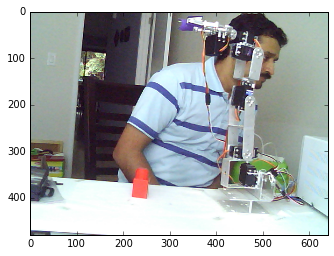

In [74]:
example.ParseFromString(pi.next())

dat = np.fromstring(example.features.feature["left_image"].bytes_list.value[0], dtype=np.uint8)

pl.imshow(dat.reshape((480, 640, 3)))